[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/monografia_modelos/blob/main/05_models_WL.ipynb)

# Modelos a partir de las caracteristicas WL

In [1]:
try:
    import google.colab
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/repos-especializacion-UdeA/monografia_modelos/refs/heads/main/init.py
    from init import init; init(force_download=False)
except ImportError:
    print("Ejecucion del notebook en entorno local")

Ejecucion del notebook en entorno local


## Objetivo a desarrollar

* Obtener diferentes modelos usando la caracteristica WL

## Actividades

To Do...

## 1. Librerias y configuraciones previas

In [2]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg


La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.


In [5]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal

# Bliblioteca de archivos
# ==============================================================================
import requests
from tqdm import tqdm
import os
import zipfile
import sys
import copy
import re

# Biblioteca libemg
# ==============================================================================
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor

# Asumo que estas importaciones ya están en tu código:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from itertools import cycle

# 2. Funciones

In [6]:
def load_data_to_model_csv(directory_path):
    """
    Carga todos los archivos CSV de un directorio, identifica si son conjuntos balanceados o desbalanceados
    según el nombre del archivo, y agrupa los datos en dos diccionarios.

    Args:
        directory_path (str): Ruta al directorio que contiene archivos CSV.

    Returns:
        tuple: (dict_imbalanced, dict_balanced) donde cada diccionario contiene DataFrames indexados por un identificador extraído del nombre del archivo.
    """
    all_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    print(f"Archivos encontrados: {all_files}")

    dict_imbalanced = {}
    dict_balanced = {}

    for file in all_files:
        file_path = os.path.join(directory_path, file)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error leyendo el archivo {file}: {e}")
            continue

        print(f"Archivo: {file}")

        # Se asume que el identificador está antes del primer guion bajo
        feature = file.split('_')[0]
        feature = feature.split('.')[0]  # Elimina la extensión del archivo

        # Clasifica en el diccionario correspondiente
        if 'imbalanced' in file.lower():
            dict_imbalanced[feature] = df
        else:
            dict_balanced[feature] = df

        print(f"Datos cargados para '{feature}': {df.shape[0]} filas, {df.shape[1]} columnas")

    return dict_imbalanced, dict_balanced

In [7]:
def train_and_select_model(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    modelo_tipo: str = 'SVM'
):
    """
    Entrena y selecciona el mejor modelo (SVM, Random Forest o KNN) usando GridSearchCV.

    Args:
        X_train (pd.DataFrame): Características del conjunto de entrenamiento.
        y_train (pd.Series): Etiquetas del conjunto de entrenamiento.
        X_test (pd.DataFrame): Características del conjunto de prueba.
        y_test (pd.Series): Etiquetas del conjunto de prueba.
        modelo_tipo (str, opcional): El tipo de modelo a entrenar.
                                     Debe ser 'SVM', 'RF' o 'KNN'. Por defecto es 'SVM'.

    Returns:
        objeto: El mejor modelo entrenado (best_estimator_ de GridSearchCV),
                o None si el modelo_tipo no es válido.
    """

    # Diccionario para configurar los modelos y sus respectivos parámetros
    modelos_config = {
        'SVM': {
            'estimador': SVC(random_state=42),
            'param_grid': {
                'C': [0.1, 1, 10, 100],
                'gamma': [1, 0.1, 0.01, 0.001],
                'kernel': ['rbf', 'linear']
            }
        },
        'RF': {
            'estimador': RandomForestClassifier(random_state=42),
            'param_grid': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'KNN': {
            'estimador': KNeighborsClassifier(),
            'param_grid': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            }
        }
    }

    # Validación de la entrada del modelo
    if modelo_tipo not in modelos_config:
        print(f"Error: Modelo '{modelo_tipo}' no válido. Por favor, elige entre {list(modelos_config.keys())}.")
        return None

    # Obtener la configuración para el modelo seleccionado
    config_actual = modelos_config[modelo_tipo]
    estimador_actual = config_actual['estimador']
    param_grid_actual = config_actual['param_grid']

    # Configurar y ejecutar GridSearchCV
    print(f"Entrenando modelo {modelo_tipo}...")
    grid_search = GridSearchCV(
        estimator=estimador_actual,
        param_grid=param_grid_actual,
        cv=5,
        scoring='accuracy',
        verbose=1 # Puedes cambiar a 2 para más detalle o 0 para menos
    )

    grid_search.fit(X_train, y_train)

    mejor_modelo = grid_search.best_estimator_

    # Imprimir los mejores hiperparámetros
    print(f"\nMejores hiperparámetros para {modelo_tipo}: {grid_search.best_params_}")

    # Realizar predicciones y evaluar el modelo
    y_pred = mejor_modelo.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Precisión del mejor modelo {modelo_tipo} en el conjunto de prueba: {accuracy:.2f}")
    print(f"Reporte de Clasificación para el mejor modelo {modelo_tipo}:\n{classification_report(y_test, y_pred)}")

    return mejor_modelo

## 3. Variables del entorno

In [8]:
ROOT_DIR =  './'
DATA_DIR =  ROOT_DIR + 'local/data/'
if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
RAW_DATA_DIR = DATA_DIR + 'raw'
if not os.path.exists(RAW_DATA_DIR):
    os.makedirs(RAW_DATA_DIR)
RAW_DATA_DIR_NPY = DATA_DIR + 'raw_numpy'
if not os.path.exists(RAW_DATA_DIR_NPY):
    os.makedirs(RAW_DATA_DIR_NPY)
RAW_SUBSET_DATA_DIR = DATA_DIR + 'raw_subset'
if not os.path.exists(RAW_SUBSET_DATA_DIR):
    os.makedirs(RAW_SUBSET_DATA_DIR)
FILTERED_SUBSET_DATA_DIR = DATA_DIR + 'filtered_subset'
if not os.path.exists(FILTERED_SUBSET_DATA_DIR):
    os.makedirs(FILTERED_SUBSET_DATA_DIR)
FEATURES_SUBSET_DATA_DIR = DATA_DIR + 'features_subset'
if not os.path.exists(FEATURES_SUBSET_DATA_DIR):
    os.makedirs(FEATURES_SUBSET_DATA_DIR)
FEATURES_SUBSET_BALANCED_DATA = DATA_DIR + 'features_subset_balanced'
if not os.path.exists(FEATURES_SUBSET_BALANCED_DATA):
    os.makedirs(FEATURES_SUBSET_BALANCED_DATA)

print("Directorio de trabajo:", ROOT_DIR)
print("Directorio de datos:", DATA_DIR)
print("Directorio de datos crudos:", RAW_DATA_DIR)
print("Directorio de datos crudos (numpy):", RAW_DATA_DIR_NPY)
print("Directorio de datos crudos (subconjunto):", RAW_SUBSET_DATA_DIR)
print("Directorio de datos filtrados (subconjunto):", FILTERED_SUBSET_DATA_DIR)
print("Directorio de datos de características (subconjunto):", FEATURES_SUBSET_DATA_DIR)
print("Directorio de datos de características (subconjunto balanceado):", FEATURES_SUBSET_BALANCED_DATA)

Directorio de trabajo: ./
Directorio de datos: ./local/data/
Directorio de datos crudos: ./local/data/raw
Directorio de datos crudos (numpy): ./local/data/raw_numpy
Directorio de datos crudos (subconjunto): ./local/data/raw_subset
Directorio de datos filtrados (subconjunto): ./local/data/filtered_subset
Directorio de datos de características (subconjunto): ./local/data/features_subset
Directorio de datos de características (subconjunto balanceado): ./local/data/features_subset_balanced


In [9]:
MODELS_DIR = ROOT_DIR + 'local/models'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

CLASSIFICARION_MODELS_DIR = MODELS_DIR + '/classification'
if not os.path.exists(CLASSIFICARION_MODELS_DIR):
    os.makedirs(CLASSIFICARION_MODELS_DIR)

SCALERS_DIR = MODELS_DIR + '/scalers'
if not os.path.exists(SCALERS_DIR):
    os.makedirs(SCALERS_DIR)

print("Directorio de modelos:", MODELS_DIR)
print("Directorio de modelos de clasificación:", CLASSIFICARION_MODELS_DIR)
print("Directorio de escaladores:", SCALERS_DIR)

Directorio de modelos: ./local/models
Directorio de modelos de clasificación: ./local/models/classification
Directorio de escaladores: ./local/models/scalers


## 4. Carga del dataset de las caracteristicas

Carga y combinación de los datos en un solo dataframe

In [10]:
FEATURES_SUBSET_BALANCED_DATA

'./local/data/features_subset_balanced'

El dataframe en el que se combinaron los datos fue: `merged_df`

In [11]:
# Load and merge CSV files
dict_imbalanced, dict_balanced = load_data_to_model_csv(FEATURES_SUBSET_BALANCED_DATA)

Archivos encontrados: ['IAV_balanced.csv', 'IAV_imbalanced.csv', 'RMS_balanced.csv', 'RMS_imbalanced.csv', 'WL_balanced.csv', 'WL_imbalanced.csv']
Archivo: IAV_balanced.csv
Datos cargados para 'IAV': 13272 filas, 11 columnas
Archivo: IAV_imbalanced.csv
Datos cargados para 'IAV': 21594 filas, 14 columnas
Archivo: RMS_balanced.csv
Datos cargados para 'RMS': 13272 filas, 11 columnas
Archivo: RMS_imbalanced.csv
Datos cargados para 'RMS': 21594 filas, 14 columnas
Archivo: WL_balanced.csv
Datos cargados para 'WL': 13272 filas, 11 columnas
Archivo: WL_imbalanced.csv
Datos cargados para 'WL': 21594 filas, 14 columnas


En los diccionarios `dict_imbalanced`, `dict_balanced` estan las caracteristicas de las señales capturadas para cada usuario. El diccionario `dict_imbalanced` se usara luego para realizar un clustering para clasificación usando kmeans.

In [15]:
dict_balanced.keys()

dict_keys(['WL', 'IAV', 'RMS'])

In [12]:
for feature_name, df in dict_balanced.items():
    print(f"{feature_name}: {df.shape}")

IAV: (13272, 11)
RMS: (13272, 11)
WL: (13272, 11)


In [13]:
# Display the first few rows of the first DataFrame
df_wl_balanced = dict_balanced['WL'].copy()
df_wl_balanced.head()

,WL_ch1,WL_ch2,WL_ch3,WL_ch4,WL_ch5,WL_ch6,WL_ch7,WL_ch8,WL_ch9,WL_ch10,restimulus
0,0.000475,1.626367e-03,0.001869,0.001035,0.004105,0.010771,0.037287,0.142162,0.005544,0.037949,0.0
1,0.000375,1.502025e-04,0.000634,0.000025,0.006091,0.013155,0.001987,0.002508,0.001761,0.032935,0.0
2,0.000001,1.533455e-07,0.000067,0.000003,0.000416,0.005391,0.001141,0.000001,0.002737,0.001122,0.0
3,0.036099,3.390028e-03,0.000168,0.000282,0.000037,0.000780,0.002508,0.038131,0.000002,0.006464,0.0
4,0.123687,1.827021e-03,0.000733,0.000173,0.000089,0.000077,0.007238,0.030180,0.000279,0.012079,0.0


In [14]:
df_wl_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13272 entries, 0 to 13271
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   WL_ch1      13272 non-null  float64
 1   WL_ch2      13272 non-null  float64
 2   WL_ch3      13272 non-null  float64
 3   WL_ch4      13272 non-null  float64
 4   WL_ch5      13272 non-null  float64
 5   WL_ch6      13272 non-null  float64
 6   WL_ch7      13272 non-null  float64
 7   WL_ch8      13272 non-null  float64
 8   WL_ch9      13272 non-null  float64
 9   WL_ch10     13272 non-null  float64
 10  restimulus  13272 non-null  float64
dtypes: float64(11)
memory usage: 1.1 MB


In [15]:
df_wl_balanced['restimulus'] = df_wl_balanced['restimulus'].astype('category')
df_wl_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13272 entries, 0 to 13271
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   WL_ch1      13272 non-null  float64 
 1   WL_ch2      13272 non-null  float64 
 2   WL_ch3      13272 non-null  float64 
 3   WL_ch4      13272 non-null  float64 
 4   WL_ch5      13272 non-null  float64 
 5   WL_ch6      13272 non-null  float64 
 6   WL_ch7      13272 non-null  float64 
 7   WL_ch8      13272 non-null  float64 
 8   WL_ch9      13272 non-null  float64 
 9   WL_ch10     13272 non-null  float64 
 10  restimulus  13272 non-null  category
dtypes: category(1), float64(10)
memory usage: 1.0 MB


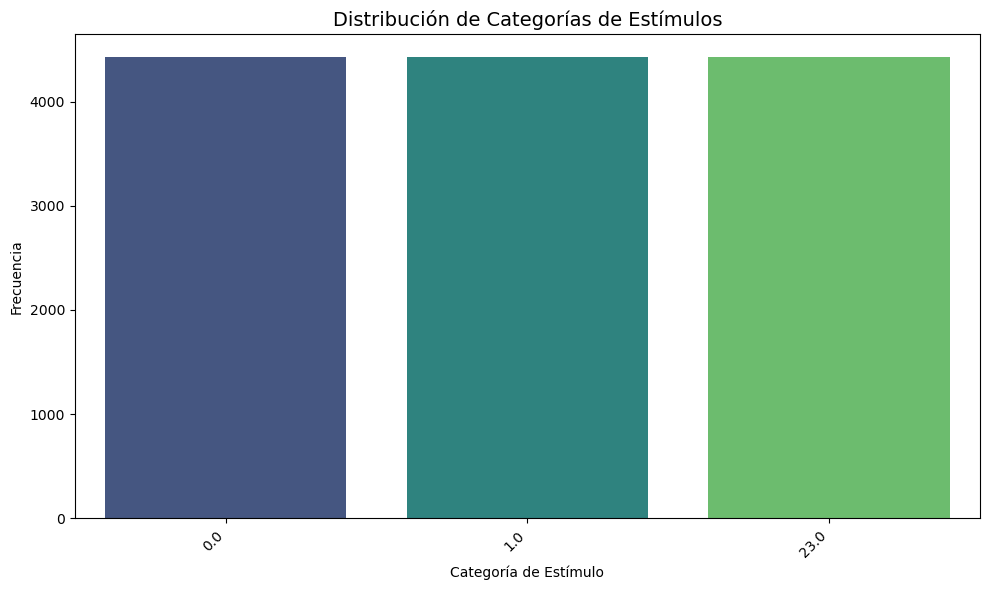

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) # Tamaño mediano
sns.countplot(data=df_wl_balanced, x='restimulus', palette='viridis')
plt.title('Distribución de Categorías de Estímulos', fontsize=14) # Título resaltado
plt.xlabel('Categoría de Estímulo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Vemos que los datos estan balanceados, por lo tanto se puede proceder a la siguiente fase.

Se separan las entradas (señal RMS) de la salida (estimulo)

In [17]:
# Separar las entradas (features) y la salida (target)
X = df_wl_balanced.drop(columns=['restimulus'])  # Entradas
y = df_wl_balanced['restimulus']  # Salida

# Mostrar las dimensiones de las entradas y la salida
print(f"Dimensiones de X (entradas): {X.shape}")
print(f"Dimensiones de y (salida): {y.shape}")

Dimensiones de X (entradas): (13272, 10)
Dimensiones de y (salida): (13272,)


Codificación de los datos

In [18]:
# Crear el codificador OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar y (reshape necesario para 1D)
y_onehot = onehot_encoder.fit_transform(y.values.reshape(-1, 1))

# Mostrar las primeras filas codificadas
print("One-hot encoded labels (primeras 5 filas):")
print(y_onehot[:5])

One-hot encoded labels (primeras 5 filas):
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## 5. Escalado

In [19]:
# Crear un objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar X
X_scaled = scaler.fit_transform(X)

# Convertir el resultado a un DataFrame para mantener los nombres de las columnas
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Mostrar las primeras filas del DataFrame escalado
X_scaled.head()

,WL_ch1,WL_ch2,WL_ch3,WL_ch4,WL_ch5,WL_ch6,WL_ch7,WL_ch8,WL_ch9,WL_ch10
0,-0.659150,-0.660056,-0.617155,-0.389271,-0.355962,-0.313126,-0.456730,0.125593,-0.483753,-0.300855
1,-0.659861,-0.673661,-0.629055,-0.399624,-0.289742,-0.290149,-0.633286,-0.724406,-0.514450,-0.334827
2,-0.662541,-0.675044,-0.634519,-0.399842,-0.478985,-0.364985,-0.637515,-0.739663,-0.506530,-0.550391
3,-0.403949,-0.643801,-0.633543,-0.396986,-0.491602,-0.409435,-0.630680,-0.507587,-0.528723,-0.514192
4,0.223499,-0.658207,-0.628096,-0.398100,-0.489887,-0.416210,-0.607022,-0.555980,-0.526476,-0.476146


Se guarda el scaler

In [20]:
# Guardar el scaler en el directorio especificado
scaler_path = os.path.join(SCALERS_DIR, 'wl_scaler_1_23.pkl')
joblib.dump(scaler, scaler_path)

print(f"Scaler guardado en: {scaler_path}")

Scaler guardado en: ./local/models/scalers\wl_scaler_1_23.pkl


## 6. División de los datos (train/test split)

Se realiza la división de los datos en conjuntos de entrenamiento y prueba en la proporsión 80 - 20

In [21]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Mostrar las dimensiones de los conjuntos resultantes
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

Dimensiones de X_train: (10617, 10)
Dimensiones de X_test: (2655, 10)
Dimensiones de y_train: (10617,)
Dimensiones de y_test: (2655,)


## 7. Modelos

### 7.1. Modelo SVM

#### 7.1.1. Entrenamiento

In [22]:
# Definir el modelo SVM
best_wl_model = train_and_select_model(
    X_train,
    y_train,
    X_test,
    y_test,
    modelo_tipo='SVM'
)

Entrenando modelo SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Mejores hiperparámetros para SVM: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Precisión del mejor modelo SVM en el conjunto de prueba: 0.83
Reporte de Clasificación para el mejor modelo SVM:
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       885
         1.0       0.88      0.75      0.81       885
        23.0       0.77      0.86      0.81       885

    accuracy                           0.83      2655
   macro avg       0.83      0.83      0.83      2655
weighted avg       0.83      0.83      0.83      2655



In [23]:
best_wl_model

SVC(C=100, gamma=0.1, random_state=42)

#### 7.1.2. Evaluación del modelo

In [25]:
# Realizar predicciones con el mejor modelo

y_pred_wl = best_wl_model.predict(X_test)

##### 7.1.2.1. Matriz de confución

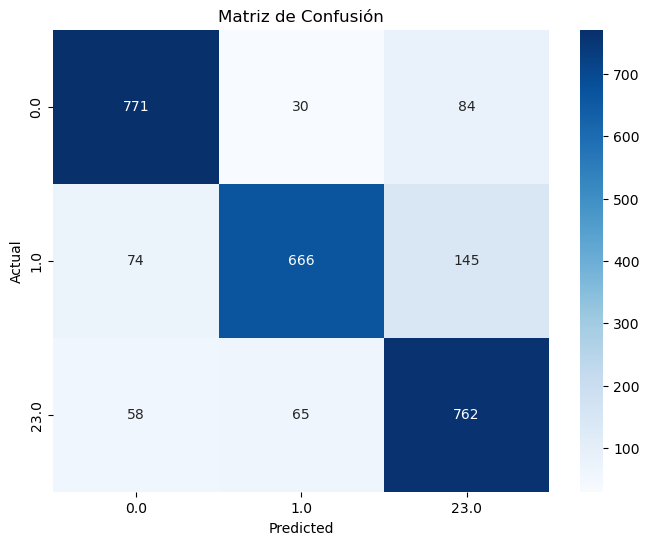

In [35]:
# Generar la matriz de confusión
conf_matrix_wl = confusion_matrix(y_test, y_pred_wl)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_wl, 
            annot=True, 
            fmt='d',                         
            cmap='Blues', 
            xticklabels=onehot_encoder.categories_[0], 
            yticklabels=onehot_encoder.categories_[0])
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### 7.1.2.3. Curva ROC

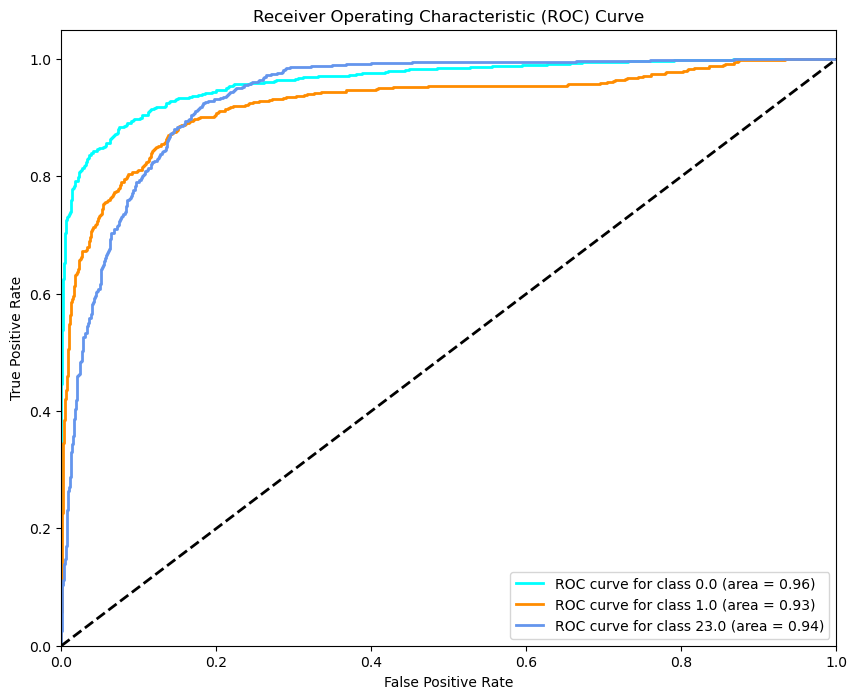

In [27]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=onehot_encoder.categories_[0])
n_classes = y_test_binarized.shape[1]

# Train a OneVsRestClassifier with the best SVM model
classifier_wl = OneVsRestClassifier(best_wl_model)
y_score_wl = classifier_wl.fit(X_train, label_binarize(y_train, classes=onehot_encoder.categories_[0])).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr_wl = dict()
tpr_wl = dict()
roc_auc_wl = dict()
for i in range(n_classes):
    fpr_wl[i], tpr_wl[i], _ = roc_curve(y_test_binarized[:, i], y_score_wl[:, i])
    roc_auc_wl[i] = auc(fpr_wl[i], tpr_wl[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_wl[i], tpr_wl[i], color=color, lw=2,
             label=f'ROC curve for class {onehot_encoder.categories_[0][i]} (area = {roc_auc_wl[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Almacenamiento del modelo

In [31]:
# Guardar el modelo SVM
wl_model_path = os.path.join(CLASSIFICARION_MODELS_DIR, 'svm_wl_model_1_23.pkl')
joblib.dump(best_wl_model, wl_model_path)

print(f"Modelo SVM guardado en: {wl_model_path}")

Modelo SVM guardado en: ./local/models/classification/svm_wl_model_1_23.pkl


#### 7.1.3. Conclusiones

To Do...

### 7.2. Modelo KNN

#### 7.2.1. Entrenamiento

In [28]:
best_knn_model = train_and_select_model(
    X_train,
    y_train,
    X_test,
    y_test,
    modelo_tipo='KNN'
)

Entrenando modelo KNN...
Fitting 5 folds for each of 72 candidates, totalling 360 fits



Mejores hiperparámetros para KNN: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Precisión del mejor modelo KNN en el conjunto de prueba: 0.84
Reporte de Clasificación para el mejor modelo KNN:
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       885
         1.0       0.89      0.76      0.82       885
        23.0       0.78      0.89      0.83       885

    accuracy                           0.84      2655
   macro avg       0.85      0.84      0.84      2655
weighted avg       0.85      0.84      0.84      2655



In [29]:
best_knn_model

KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')

#### 7.2.2. Evaluación del modelo

In [30]:
# Realizar predicciones con el mejor modelo

y_pred_knn = best_knn_model.predict(X_test)

##### 7.2.3.1. Matriz de confución

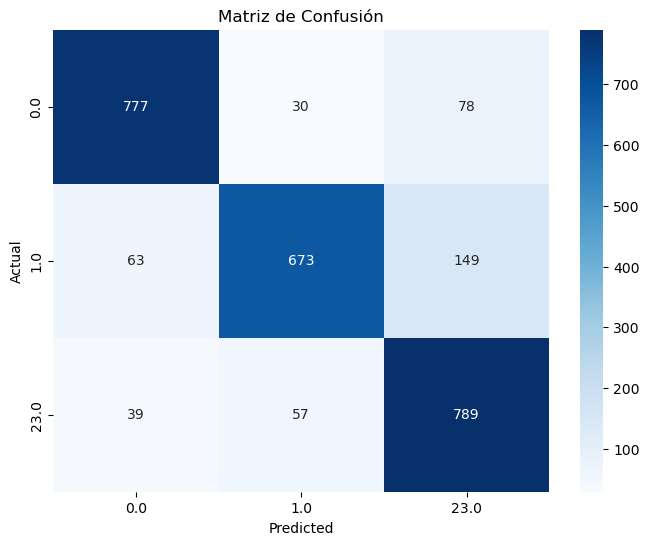

In [32]:
# Generar la matriz de confusión
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, 
            annot=True, fmt='d', 
            cmap='Blues', 
            xticklabels=onehot_encoder.categories_[0], 
            yticklabels=onehot_encoder.categories_[0])
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### 7.2.3.1. Curva ROC

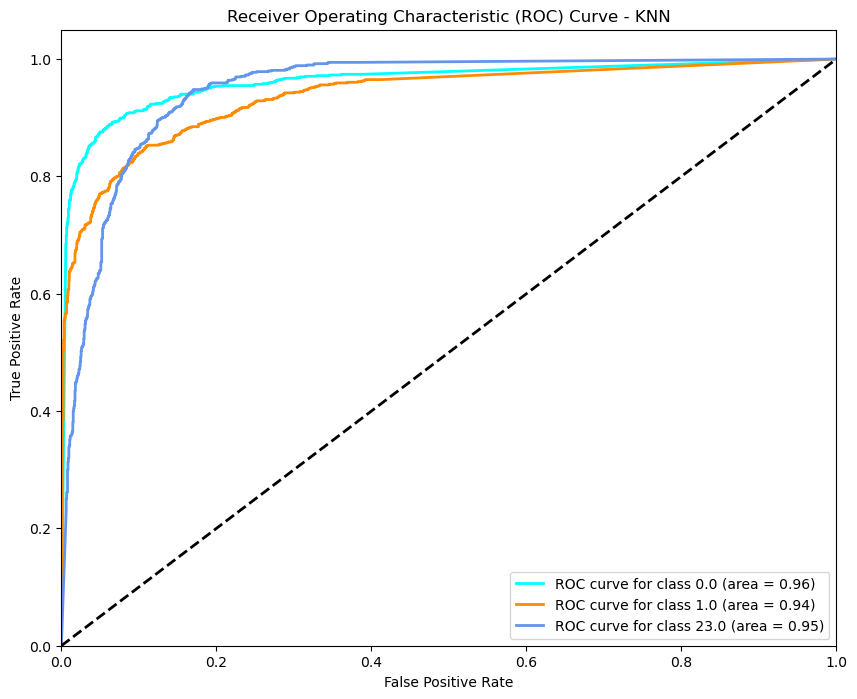

In [33]:
# Binarizar las etiquetas de salida
y_test_binarized = label_binarize(y_test, classes=onehot_encoder.categories_[0])
n_classes = y_test_binarized.shape[1]

# Entrenar un clasificador OneVsRest con el mejor modelo KNN
classifier_knn = OneVsRestClassifier(best_knn_model)
y_score_knn = classifier_knn.fit(X_train, label_binarize(y_train, classes=onehot_encoder.categories_[0])).predict_proba(X_test)

# Calcular la curva ROC y el área bajo la curva (AUC) para cada clase
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_binarized[:, i], y_score_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_knn[i], tpr_knn[i], color=color, lw=2,
             label=f'ROC curve for class {onehot_encoder.categories_[0][i]} (area = {roc_auc_knn[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc="lower right")
plt.show()

Almacenamiento del modelo

In [37]:
# Guardar el modelo KNN
knn_model_path = os.path.join(CLASSIFICARION_MODELS_DIR, 'knn_wl_model_1_23.pkl')
joblib.dump(best_knn_model, knn_model_path)

print(f"Modelo KNN guardado en: {knn_model_path}")

Modelo KNN guardado en: ./local/models/classification/knn_wl_model_1_23.pkl


#### 7.2.3. Conclusiones

To Do...

### 7.3. Modelo RF

#### 7.3.1. Entrenamiento

In [34]:
best_rf_model = train_and_select_model(
    X_train,
    y_train,
    X_test,
    y_test,
    modelo_tipo='RF'
)

Entrenando modelo RF...
Fitting 5 folds for each of 81 candidates, totalling 405 fits



Mejores hiperparámetros para RF: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Precisión del mejor modelo RF en el conjunto de prueba: 0.85
Reporte de Clasificación para el mejor modelo RF:
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       885
         1.0       0.85      0.80      0.82       885
        23.0       0.80      0.88      0.84       885

    accuracy                           0.85      2655
   macro avg       0.86      0.85      0.85      2655
weighted avg       0.86      0.85      0.85      2655



In [36]:
best_rf_model

RandomForestClassifier(n_estimators=200, random_state=42)

#### 7.3.2. Evaluación del modelo

In [37]:
# Realizar predicciones con el mejor modelo

y_pred_rf = best_rf_model.predict(X_test)

##### 7.3.2.1. Matriz de confución

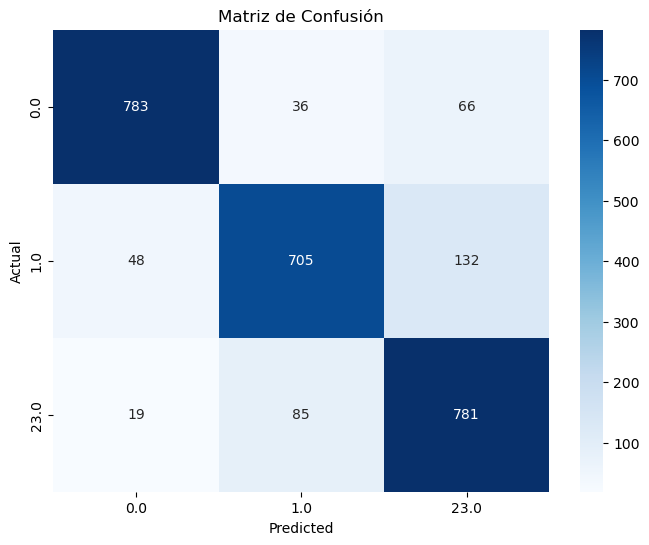

In [38]:
# Generar la matriz de confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=onehot_encoder.categories_[0], 
            yticklabels=onehot_encoder.categories_[0])
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### 7.3.2.2. Curva ROC

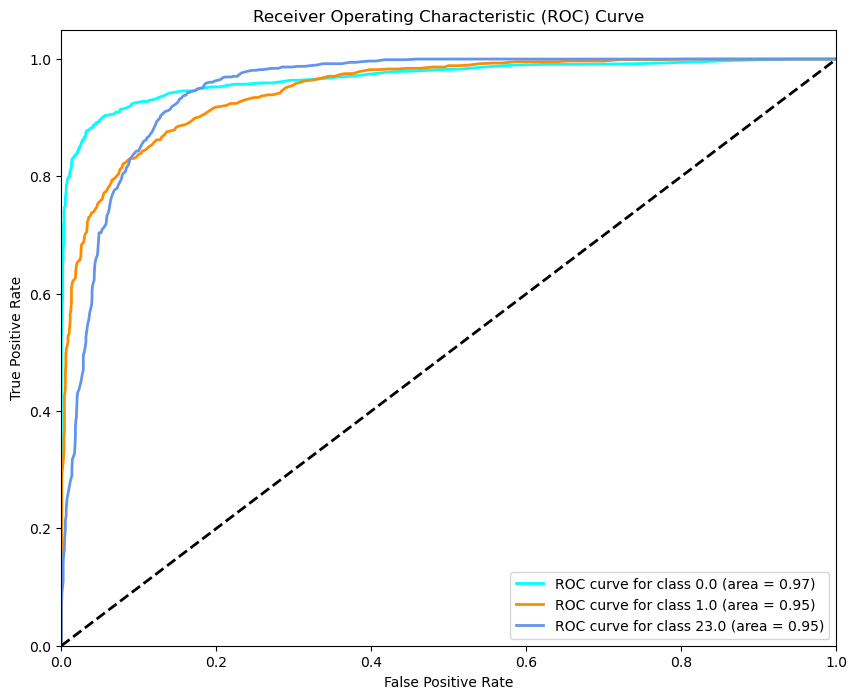

In [39]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=onehot_encoder.categories_[0])
n_classes = y_test_binarized.shape[1]

# Train a OneVsRestClassifier with the best RF model
classifier_rf = OneVsRestClassifier(best_rf_model)
y_score_rf = classifier_rf.fit(X_train, label_binarize(y_train, classes=onehot_encoder.categories_[0])).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized[:, i], y_score_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=2,
             label=f'ROC curve for class {onehot_encoder.categories_[0][i]} (area = {roc_auc_rf[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Almacenamiento del modelo

In [40]:
# Guardar el modelo RF
rf_model_path = os.path.join(CLASSIFICARION_MODELS_DIR, 'rf_wl_model_1_23.pkl')
joblib.dump(best_rf_model, rf_model_path)

print(f"Modelo RF guardado en: {rf_model_path}")

Modelo RF guardado en: ./local/models/classification\rf_wl_model_1_23.pkl


#### 7.3.3. Conclusiones del modelo

To Do...